In [1]:
import numpy as np
from netCDF4 import Dataset
import glob
from matplotlib import pyplot as plt

In [2]:
def Load_SST(file):
    dataset = []
    rn1,rm1,rn2,rm2 = (128,128, 384, 640)

    data = Dataset(file)
    T = data.variables['thetao'][:]
    _,_,n,m = T.shape
    T = T.reshape((n,m)).filled(T.min())
    T = np.flipud(T)
    T = T[rn1:rn2,rm1:rm2]
    for i in range(4):
        for j in range(8):
            sub_region = T[i*64:(i+1)*64,j*64:(j+1)*64]
            dataset.append(sub_region)
    return dataset

In [3]:
files = sorted(glob.glob('/users/Etu9/21205099/CMEMS_DATA'+'/*.nc'))
# T = Load_SST(files[2])
# plt.imshow(T)

i = 20
dataset = []
dataset_new = []
data_1 = Load_SST(files[i])
data_2 = Load_SST(files[i + 1]) if i + 1 < len(files) else None
if data_2 != None:
    for sub_data1, sub_data2 in zip(data_1, data_2):
        sub_data1 = np.expand_dims(sub_data1, axis=0)
        sub_data2 = np.expand_dims(sub_data2, axis=0)
        data_1_RGB = np.vstack((sub_data1, sub_data1, sub_data1))
        data_2_RGB = np.vstack((sub_data2, sub_data2, sub_data2))
        data = np.concatenate((data_1_RGB, data_2_RGB), axis=0)
        dataset.append(data)
print(np.array(dataset).shape)
mean = np.mean(np.array(dataset))
std = np.std(np.array(dataset))
for data in dataset:
    data = (data - mean) / std
    dataset_new.append(data)

(32, 6, 64, 64)


In [4]:
import torch
from unsup_semi_lagran import Unsupervised
model = Unsupervised()
dict = torch.load('./Checkpoints/Unsupervised/FlowNetS/training_state.pt')
model.load_state_dict(dict['model_state_dict'])
model.eval()
input = torch.tensor(np.array(dataset_new), dtype=torch.float32)
with torch.no_grad():
    output = model(input)

/users/Etu9/21205099/.conda/envs/prat/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def flow2rgb(flow_map, max_value=None):
    flow_map_np = flow_map.detach().cpu().numpy()
    _, h, w = flow_map_np.shape
    flow_map_np[:,(flow_map_np[0] == 0) & (flow_map_np[1] == 0)] = float('nan')
    rgb_map = np.ones((3,h,w)).astype(np.float32)
    if max_value is not None:
        normalized_flow_map = flow_map_np / max_value
    else:
        normalized_flow_map = flow_map_np / (np.abs(flow_map_np).max())
    rgb_map[0] += normalized_flow_map[0]
    rgb_map[1] -= 0.5*(normalized_flow_map[0] + normalized_flow_map[1])
    rgb_map[2] += normalized_flow_map[1]
    return rgb_map.clip(0,1)


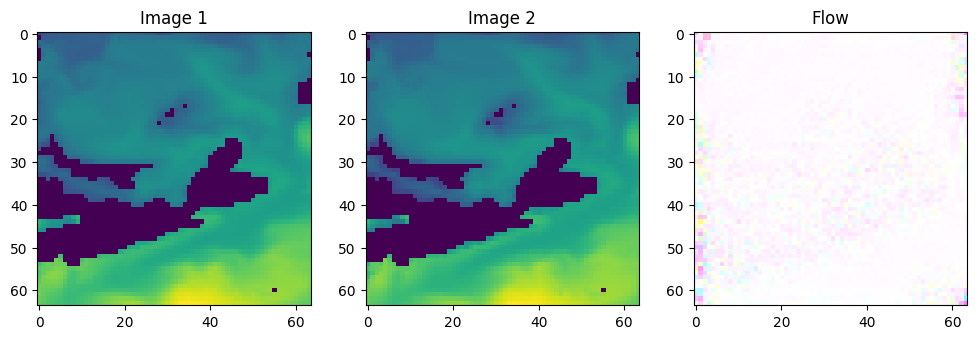

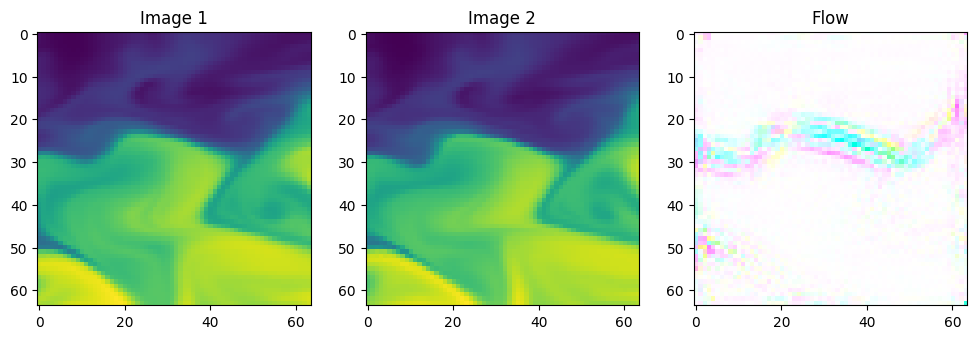

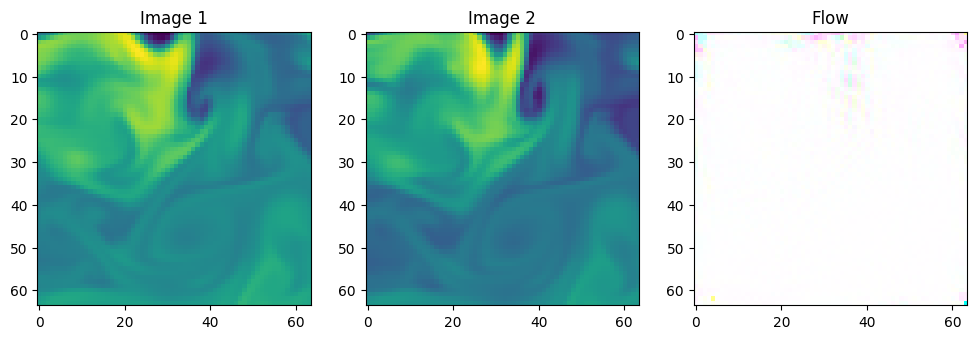

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input[8, 0])
axes[0].set_title('Image 1')
axes[1].imshow(input[8, 3])
axes[1].set_title('Image 2')
axes[2].imshow(flow2rgb(output[0][0][8]).transpose(1,2,0))
axes[2].set_title('Flow')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input[16, 0])
axes[0].set_title('Image 1')
axes[1].imshow(input[16, 3])
axes[1].set_title('Image 2')
axes[2].imshow(flow2rgb(output[0][0][16]).transpose(1,2,0))
axes[2].set_title('Flow')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input[24, 0])
axes[0].set_title('Image 1')
axes[1].imshow(input[24, 3])
axes[1].set_title('Image 2')
axes[2].imshow(flow2rgb(output[0][0][24]).transpose(1,2,0))
axes[2].set_title('Flow')
plt.show()